In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time 
import os
from tqdm import tqdm


In [2]:
class DownConvolution(tf.keras.layers.Layer):
    def __init__(self):
        super(DownConvolution,self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(128,kernel_size=3,strides=2,padding='same')
        self.conv2 = tf.keras.layers.Conv2D(128,kernel_size=3,strides=1,padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        
        self.conv3 = tf.keras.layers.Conv2D(256,kernel_size=3,strides=2,padding='same')
        self.conv4 = tf.keras.layers.Conv2D(256,kernel_size=3,strides=1,padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
                   
    def call(self,input_tensor,training=False):
        x = self.conv1(input_tensor)
        x = self.conv2(x)
        x = self.bn1(x , training = training)
        x = tf.nn.relu(x)
        
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.bn2(x, training= training)
        x = tf.nn.relu(x)
        return x 

In [3]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self):
        super(ResidualBlock,self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(256, kernel_size=3, strides=1,padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        
        self.conv2 = tf.keras.layers.Conv2D(256, kernel_size=3, strides=1,padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
               
    def call(self,input_tensor,training=False):
        x = self.conv1(input_tensor)
        x = self.bn1(x, training = training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training= training)
        return x + input_tensor

In [4]:
class UpConvolution(tf.keras.layers.Layer):
    def __init__(self):
        super(UpConvolution,self).__init__()
        self.trans_conv1 = tf.keras.layers.Conv2DTranspose(128,kernel_size=3,strides=2,padding='same')
        self.trans_conv2 = tf.keras.layers.Conv2DTranspose(128,kernel_size=3,strides=1,padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
    
        self.trans_conv3 = tf.keras.layers.Conv2DTranspose(64,kernel_size=3,strides=2,padding='same')
        self.trans_conv4 = tf.keras.layers.Conv2DTranspose(64,kernel_size=3,strides=1,padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
    
    def call(self,input_tensor,training=False):
        x = self.trans_conv1(input_tensor)
        x = self.trans_conv2(x)
        x = self.bn1(x, training = training)
        x = tf.nn.relu(x)
        
        x = self.trans_conv3(x)
        x = self.trans_conv4(x)
        x = self.bn2(x)
        x = tf.nn.relu(x)
        return x

In [5]:
class generator(tf.keras.Model):
    def __init__(self):
        super(generator,self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(64,kernel_size=7,strides=1,padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        
        self.down_conv = DownConvolution()
        
        self.residual1 = ResidualBlock()
        self.residual2 = ResidualBlock()
        self.residual3 = ResidualBlock()
        self.residual4 = ResidualBlock()
        self.residual5 = ResidualBlock()
        self.residual6 = ResidualBlock()
        self.residual7 = ResidualBlock()
        self.residual8 = ResidualBlock()
        
        self.up_conv = UpConvolution()
        
        self.conv2 = tf.keras.layers.Conv2D(3, kernel_size=7, strides=1,padding='same')
        
    def call(self,input_tensor,training=False):
        
        x = self.conv1(input_tensor)
        x = self.bn1(x)
        x = tf.nn.relu(x)
        
        x = self.down_conv(x)
        
        x = self.residual1(x)
        x = self.residual2(x)
        x = self.residual3(x)
        x = self.residual4(x)
        x = self.residual5(x)
        x = self.residual6(x)
        x = self.residual7(x)
        x = self.residual8(x)
        
        x = self.up_conv(x)
        x = self.conv2(x)
        x = tf.nn.tanh(x)
        return x


In [6]:
class discriminator(tf.keras.Model):
    def __init__(self):
        super(discriminator,self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32,kernel_size=3,strides=1,padding='same')
        
        self.conv2 = tf.keras.layers.Conv2D(64,kernel_size=3, strides=2, padding='same')
        self.conv3 = tf.keras.layers.Conv2D(128,kernel_size=3,strides=1, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        
        self.conv4 = tf.keras.layers.Conv2D(128,kernel_size=3,strides=2,padding='same')
        self.conv5 = tf.keras.layers.Conv2D(256,kernel_size=3, strides=1, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        
        self.conv6 = tf.keras.layers.Conv2D(256,kernel_size=3, strides=1, padding='same')
        self.bn3 = tf.keras.layers.BatchNormalization()      
        
        self.conv7 = tf.keras.layers.Conv2D(1,kernel_size=3, strides=1, padding='same')
    
    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = tf.nn.leaky_relu(x)
        
        x = self.conv2(x)
        x = tf.nn.leaky_relu(x)
        x = self.conv3(x)
        x = self.bn1(x, training= training)
        x = tf.nn.leaky_relu(x)
        
        x = self.conv4(x)
        x = tf.nn.leaky_relu(x)
        x = self.conv5(x)
        x = self.bn2(x, training = training)
        x = tf.nn.leaky_relu(x)
        
        x = self.conv6(x)
        x = self.bn3(x, training= training)
        x = tf.nn.leaky_relu(x)
        
        x = self.conv7(x)
        return x    

In [7]:
def make_edge_smooth(img) :
    kernel_size = 5
    img_size = 256
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    gauss = cv2.getGaussianKernel(kernel_size, 0)
    gauss = gauss * gauss.transpose(1, 0)

    bgr_img = img
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    bgr_img = cv2.resize(bgr_img, (img_size, img_size))
    pad_img = np.pad(bgr_img, ((2, 2), (2, 2), (0, 0)), mode='reflect')
    gray_img = cv2.resize(gray_img, (img_size, img_size))

    edges = cv2.Canny(gray_img, 100, 200)
    dilation = cv2.dilate(edges, kernel)
    plt.imshow(dilation)
    gauss_img = np.copy(bgr_img)
    idx = np.where(dilation != 0)
    for i in range(np.sum(dilation != 0)):
        gauss_img[idx[0][i], idx[1][i], 0] = np.sum(
            np.multiply(pad_img[idx[0][i]:idx[0][i] + kernel_size, idx[1][i]:idx[1][i] + kernel_size, 0], gauss))
        gauss_img[idx[0][i], idx[1][i], 1] = np.sum(
            np.multiply(pad_img[idx[0][i]:idx[0][i] + kernel_size, idx[1][i]:idx[1][i] + kernel_size, 1], gauss))
        gauss_img[idx[0][i], idx[1][i], 2] = np.sum(
            np.multiply(pad_img[idx[0][i]:idx[0][i] + kernel_size, idx[1][i]:idx[1][i] + kernel_size, 2], gauss))
    return gauss_img

In [8]:
if os.path.isdir('smooth_data'):
    pass
else:
    os.mkdir('smooth_data')
    filenames = os.listdir('target_data')
    for filename in tqdm(filenames):
        img = cv2.imread(f'target_data/{filename}')
        img = make_edge_smooth(img)
        cv2.imwrite(f"smooth_data/{filename}",img)

In [9]:
src_ds = tf.data.Dataset.list_files('./src_data/*', shuffle=False)
orig_tgt_ds = tf.data.Dataset.list_files('./target_data/*', shuffle=False)
sms_ds = tf.data.Dataset.list_files('./smooth_data/*', shuffle=False)

In [10]:
def src_load(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [256, 256])

In [11]:
def tgt_load(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [256, 256])

In [12]:
src_ds = src_ds.map(src_load, num_parallel_calls=tf.data.experimental.AUTOTUNE)
orig_tgt_ds = orig_tgt_ds.map(tgt_load, num_parallel_calls=tf.data.experimental.AUTOTUNE)
sms_ds = sms_ds.map(tgt_load, num_parallel_calls=tf.data.experimental.AUTOTUNE)

src_ds = src_ds.map(lambda x: x/127.5-1)
orig_tgt_ds = orig_tgt_ds.map(lambda x: x/127.5-1)
sms_ds = sms_ds.map(lambda x: x/127.5-1)

In [13]:
tgt_ds = tf.data.Dataset.zip((orig_tgt_ds,sms_ds))

In [14]:
src_ds = src_ds.shuffle(400).batch(8)
tgt_ds = tgt_ds.shuffle(400).batch(8)

In [15]:
print(len(src_ds))
print(len(tgt_ds))

448
747


In [16]:
len(orig_tgt_ds)

5970

In [17]:
len(sms_ds)

5970

In [18]:
disc = discriminator()
gen = generator()
input_d = tf.keras.Input(shape=(None,None,3))
output_d = disc(input_d)
d = tf.keras.Model(inputs=input_d,outputs=output_d)

input_g = tf.keras.Input(shape=(None,None,3))
output_g = gen(input_g)
g = tf.keras.Model(inputs=input_g,outputs=output_g)

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
L1_loss = tf.keras.losses.MeanAbsoluteError()

def adversarial_loss(real_output, smooth_output,fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    smooth_loss = cross_entropy(tf.ones_like(smooth_output),real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    
    total_loss = real_loss + fake_loss + smooth_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

def content_loss(src_feature, reconstruct_feature):
    return L1_loss(src_feature, reconstruct_feature)

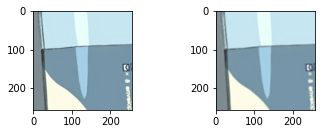

In [20]:
for i in tgt_ds.take(1):
    plt.subplot(221)
    plt.imshow(((i[0][0].numpy()+1)*127.5).astype(np.uint8))
    
    plt.subplot(222)
    plt.imshow(((i[1][0].numpy()+1)*127.5).astype(np.uint8))

In [21]:
vgg19 = tf.keras.applications.VGG19(weights='imagenet',input_shape=(None,None,3),include_top=False)
feature_extracter = tf.keras.Model(inputs=vgg19.input,outputs=vgg19.get_layer('block4_conv4').output)

In [22]:
def VGG(input_tensor,feature_extracter):
    return feature_extracter(input_tensor)

In [23]:
for epoch in range(1,11):
    pretrain_loss = 0.0
    start_time = time.time()
    for src_batch in tqdm(src_ds):
        with tf.GradientTape() as gen_tape:
            generated_img = g(src_batch, training=True)

            reconstruct_feature = VGG(generated_img,feature_extracter) 
            src_feature = VGG(src_batch,feature_extracter)

            c_loss = 10 * content_loss(reconstruct_feature,src_feature)
            pretrain_loss += c_loss

        gradients_of_generator = gen_tape.gradient(c_loss, g.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, g.trainable_variables))

    print(f'epoch : {epoch}, time : {time.time()-start_time} , pretrain_loss : {pretrain_loss}')

  0%|          | 0/448 [00:00<?, ?it/s]

epoch : 1, time : 202.51183223724365 , pretrain_loss : 1940.675537109375


  0%|          | 0/448 [00:00<?, ?it/s]

epoch : 2, time : 200.62259078025818 , pretrain_loss : 1106.112060546875


  0%|          | 0/448 [00:00<?, ?it/s]

epoch : 3, time : 200.62068223953247 , pretrain_loss : 919.3934326171875


  0%|          | 0/448 [00:00<?, ?it/s]

epoch : 4, time : 200.66606950759888 , pretrain_loss : 805.4169311523438


  0%|          | 0/448 [00:00<?, ?it/s]

epoch : 5, time : 200.6984248161316 , pretrain_loss : 729.7996826171875


  0%|          | 0/448 [00:00<?, ?it/s]

epoch : 6, time : 200.71858549118042 , pretrain_loss : 675.48193359375


  0%|          | 0/448 [00:00<?, ?it/s]

epoch : 7, time : 200.68323516845703 , pretrain_loss : 639.9923706054688


  0%|          | 0/448 [00:00<?, ?it/s]

epoch : 8, time : 200.65075254440308 , pretrain_loss : 618.342041015625


  0%|          | 0/448 [00:00<?, ?it/s]

epoch : 9, time : 200.67638444900513 , pretrain_loss : 593.6345825195312


100%|██████████| 448/448 [03:20<00:00,  2.23it/s]


epoch : 10, time : 200.60636496543884 , pretrain_loss : 555.6156616210938


In [24]:
tf.keras.models.save_model(g,'pretrain')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: pretrain/assets


In [ ]:
for epoch in range(1,201):
    start_time = time.time()
    total_loss=0.0
    total_gen_loss = 0.0
    total_adv_loss = 0.0
    for src_batch, tgt_batch in tqdm(zip(src_ds,tgt_ds)):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_img = g(src_batch, training=True)

            reconstruct_feature = VGG(generated_img,feature_extracter) 
            src_feature = VGG(src_batch,feature_extracter)

            c_loss = content_loss(reconstruct_feature,src_feature)

            fake_loss = d(generated_img,training=True)
            real_loss = d(tgt_batch[0],training=True)
            smooth_loss = d(tgt_batch[1],training=True)

            adv_loss = adversarial_loss(real_loss, smooth_loss, fake_loss)
            gen_loss = generator_loss(fake_loss)


            total_gen_loss += gen_loss + 10 * c_loss
            total_adv_loss += adv_loss
            
            total_loss += adv_loss + total_gen_loss

        gradients_of_generator = gen_tape.gradient(total_gen_loss, g.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(adv_loss, d.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, g.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, d.trainable_variables))
    total_loss = total_loss/len(src_batch)
    total_gen_loss = total_gen_loss/len(src_batch)
    total_adv_loss = total_adv_loss/len(src_batch)
    
    tf.keras.models.save_model(g,f'checkpoint/generator_{epoch}')
    tf.keras.models.save_model(d,f'checkpoint/discriminator_{epoch}')
    
    if os.path.isdir(f'results/{epoch}'):
        pass
    else:
        os.mkdir(f'results/{epoch}')

    filenames = os.listdir('src_data')
    for filename in tqdm(filenames):
        img_array = np.fromfile(f'src_data/{filename}', np.uint8)
        img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
        img = g((img[tf.newaxis,...]/127.5-1).astype('float32'))
        cv2.imwrite(f"results/{epoch}/{filename}",(((img[0]+1)*127.5).numpy()).astype(np.uint8))

    print(f'epoch : {epoch}, time : {time.time()-start_time} , total_loss : {total_loss} , gen_loss : {total_gen_loss} ,disc_loss : {adv_loss}')

448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_1/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_1/assets


100%|██████████| 3584/3584 [01:35<00:00, 31.82it/s]
0it [00:00, ?it/s]

epoch : 1, time : 432.01059103012085 , total_loss : 28374.3828125 , gen_loss : 124.04872131347656 ,disc_loss : 1.558639407157898


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_2/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_2/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.31it/s]
0it [00:00, ?it/s]

epoch : 2, time : 402.27783608436584 , total_loss : 28862.912109375 , gen_loss : 126.49354553222656 ,disc_loss : 1.3592724800109863


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_3/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_3/assets


100%|██████████| 3584/3584 [01:06<00:00, 53.74it/s]
0it [00:00, ?it/s]

epoch : 3, time : 403.3682975769043 , total_loss : 31308.98046875 , gen_loss : 139.21376037597656 ,disc_loss : 1.5061452388763428


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_4/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_4/assets


100%|██████████| 3584/3584 [01:06<00:00, 54.05it/s]
0it [00:00, ?it/s]

epoch : 4, time : 402.642050743103 , total_loss : 35825.58203125 , gen_loss : 157.10824584960938 ,disc_loss : 1.292982578277588


448it [05:30,  1.35it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_5/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_5/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.39it/s]
0it [00:00, ?it/s]

epoch : 5, time : 401.9662675857544 , total_loss : 38592.1015625 , gen_loss : 167.582275390625 ,disc_loss : 1.8332328796386719


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_6/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_6/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.47it/s]
0it [00:00, ?it/s]

epoch : 6, time : 402.37730383872986 , total_loss : 41063.21875 , gen_loss : 180.8889617919922 ,disc_loss : 0.6590242981910706


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_7/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_7/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.43it/s]
0it [00:00, ?it/s]

epoch : 7, time : 402.01734161376953 , total_loss : 48468.7734375 , gen_loss : 209.8270263671875 ,disc_loss : 1.6718612909317017


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_8/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_8/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.75it/s]
0it [00:00, ?it/s]

epoch : 8, time : 401.56753754615784 , total_loss : 48498.921875 , gen_loss : 212.82211303710938 ,disc_loss : 1.8484387397766113


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_9/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_9/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.66it/s]
0it [00:00, ?it/s]

epoch : 9, time : 401.6922039985657 , total_loss : 52669.09765625 , gen_loss : 233.0060577392578 ,disc_loss : 1.7204608917236328


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_10/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_10/assets


100%|██████████| 3584/3584 [01:06<00:00, 54.19it/s]
0it [00:00, ?it/s]

epoch : 10, time : 402.12491250038147 , total_loss : 55853.484375 , gen_loss : 244.16188049316406 ,disc_loss : 1.2414582967758179


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_11/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_11/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.41it/s]
0it [00:00, ?it/s]

epoch : 11, time : 401.9699466228485 , total_loss : 58643.93359375 , gen_loss : 250.03268432617188 ,disc_loss : 1.5028319358825684


448it [05:30,  1.35it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_12/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_12/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.46it/s]
0it [00:00, ?it/s]

epoch : 12, time : 401.9927439689636 , total_loss : 59854.94140625 , gen_loss : 264.4602966308594 ,disc_loss : 0.8207906484603882


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_13/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_13/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.58it/s]
0it [00:00, ?it/s]

epoch : 13, time : 401.6418242454529 , total_loss : 65120.7734375 , gen_loss : 283.01385498046875 ,disc_loss : 1.2484986782073975


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_14/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_14/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.97it/s]
0it [00:00, ?it/s]

epoch : 14, time : 401.9634909629822 , total_loss : 64571.2265625 , gen_loss : 280.93719482421875 ,disc_loss : 1.0885939598083496


448it [05:30,  1.35it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_15/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_15/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.47it/s]
0it [00:00, ?it/s]

epoch : 15, time : 402.27719807624817 , total_loss : 68909.9375 , gen_loss : 299.8186340332031 ,disc_loss : 0.8147281408309937


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_16/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_16/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.62it/s]
0it [00:00, ?it/s]

epoch : 16, time : 401.6186010837555 , total_loss : 67630.9140625 , gen_loss : 294.4031982421875 ,disc_loss : 1.3080267906188965


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_17/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_17/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.27it/s]
0it [00:00, ?it/s]

epoch : 17, time : 401.55064630508423 , total_loss : 67336.84375 , gen_loss : 294.548095703125 ,disc_loss : 1.0448451042175293


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_18/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_18/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.05it/s]
0it [00:00, ?it/s]

epoch : 18, time : 402.26472187042236 , total_loss : 67324.4765625 , gen_loss : 294.3329162597656 ,disc_loss : 1.3463197946548462


448it [05:29,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_19/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_19/assets


100%|██████████| 3584/3584 [01:06<00:00, 54.19it/s]
0it [00:00, ?it/s]

epoch : 19, time : 401.9761497974396 , total_loss : 69406.109375 , gen_loss : 300.38470458984375 ,disc_loss : 0.4290504455566406


448it [05:29,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_20/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_20/assets


100%|██████████| 3584/3584 [01:06<00:00, 50.65it/s]
0it [00:00, ?it/s]

epoch : 20, time : 402.01411962509155 , total_loss : 68852.65625 , gen_loss : 300.31170654296875 ,disc_loss : 0.5643476843833923


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_21/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_21/assets


100%|██████████| 3584/3584 [01:06<00:00, 54.28it/s]
0it [00:00, ?it/s]

epoch : 21, time : 402.25740575790405 , total_loss : 69782.4765625 , gen_loss : 304.3199157714844 ,disc_loss : 0.9334295988082886


448it [05:30,  1.35it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_22/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_22/assets


100%|██████████| 3584/3584 [01:05<00:00, 49.62it/s]
0it [00:00, ?it/s]

epoch : 22, time : 401.4589126110077 , total_loss : 69156.84375 , gen_loss : 299.12811279296875 ,disc_loss : 1.1502721309661865


448it [05:30,  1.37it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_23/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_23/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.97it/s]
0it [00:00, ?it/s]

epoch : 23, time : 401.80725502967834 , total_loss : 69990.25 , gen_loss : 305.7259216308594 ,disc_loss : 1.4522638320922852


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_24/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_24/assets


100%|██████████| 3584/3584 [01:05<00:00, 49.58it/s]
0it [00:00, ?it/s]

epoch : 24, time : 402.09495091438293 , total_loss : 69388.75 , gen_loss : 303.22869873046875 ,disc_loss : 1.5217926502227783


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_25/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_25/assets


100%|██████████| 3584/3584 [01:06<00:00, 54.20it/s]
0it [00:00, ?it/s]

epoch : 25, time : 402.4047477245331 , total_loss : 72019.890625 , gen_loss : 313.66192626953125 ,disc_loss : 1.3461406230926514


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_26/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_26/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.82it/s]
0it [00:00, ?it/s]

epoch : 26, time : 401.3110806941986 , total_loss : 71063.375 , gen_loss : 310.108154296875 ,disc_loss : 0.46329265832901


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_27/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_27/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.70it/s]
0it [00:00, ?it/s]

epoch : 27, time : 402.17231917381287 , total_loss : 70568.2421875 , gen_loss : 306.61712646484375 ,disc_loss : 0.6066064238548279


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_28/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_28/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.72it/s]
0it [00:00, ?it/s]

epoch : 28, time : 401.4858627319336 , total_loss : 71305.7578125 , gen_loss : 310.5159606933594 ,disc_loss : 0.4689405560493469


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_29/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_29/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.58it/s]
0it [00:00, ?it/s]

epoch : 29, time : 401.4669804573059 , total_loss : 70575.8125 , gen_loss : 307.4408264160156 ,disc_loss : 0.6271640658378601


448it [05:30,  1.35it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_30/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_30/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.55it/s]
0it [00:00, ?it/s]

epoch : 30, time : 401.9014821052551 , total_loss : 70988.1796875 , gen_loss : 309.2715759277344 ,disc_loss : 0.6253259778022766


448it [05:29,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_31/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_31/assets


100%|██████████| 3584/3584 [01:06<00:00, 50.37it/s]
0it [00:00, ?it/s]

epoch : 31, time : 401.9561221599579 , total_loss : 70970.84375 , gen_loss : 308.40447998046875 ,disc_loss : 0.6762131452560425


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_32/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_32/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.52it/s]
0it [00:00, ?it/s]

epoch : 32, time : 401.3141119480133 , total_loss : 71352.6171875 , gen_loss : 311.2892761230469 ,disc_loss : 1.002840518951416


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_33/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_33/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.69it/s]
0it [00:00, ?it/s]

epoch : 33, time : 401.5828423500061 , total_loss : 71645.859375 , gen_loss : 311.5540771484375 ,disc_loss : 0.5218938589096069


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_34/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_34/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.54it/s]
0it [00:00, ?it/s]

epoch : 34, time : 401.8118095397949 , total_loss : 71010.65625 , gen_loss : 309.04156494140625 ,disc_loss : 1.0794367790222168


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_35/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_35/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.44it/s]
0it [00:00, ?it/s]

epoch : 35, time : 401.8430368900299 , total_loss : 70568.6015625 , gen_loss : 309.1273498535156 ,disc_loss : 1.5534824132919312


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_36/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_36/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.43it/s]
0it [00:00, ?it/s]

epoch : 36, time : 401.9157304763794 , total_loss : 70795.78125 , gen_loss : 308.1486511230469 ,disc_loss : 1.541200876235962


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_37/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_37/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.38it/s]
0it [00:00, ?it/s]

epoch : 37, time : 402.17714834213257 , total_loss : 71380.125 , gen_loss : 308.5788269042969 ,disc_loss : 0.955883800983429


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_38/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_38/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.50it/s]
0it [00:00, ?it/s]

epoch : 38, time : 401.3742127418518 , total_loss : 71275.4296875 , gen_loss : 309.9308776855469 ,disc_loss : 1.0763052701950073


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_39/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_39/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.60it/s]
0it [00:00, ?it/s]

epoch : 39, time : 401.9342358112335 , total_loss : 70959.265625 , gen_loss : 308.3808898925781 ,disc_loss : 2.246100425720215


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_40/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_40/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.48it/s]
0it [00:00, ?it/s]

epoch : 40, time : 401.98656392097473 , total_loss : 70301.8671875 , gen_loss : 305.0131530761719 ,disc_loss : 0.835149884223938


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_41/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_41/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.59it/s]
0it [00:00, ?it/s]

epoch : 41, time : 401.66016936302185 , total_loss : 70655.0546875 , gen_loss : 307.8356018066406 ,disc_loss : 0.526007354259491


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_42/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_42/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.42it/s]
0it [00:00, ?it/s]

epoch : 42, time : 401.97329926490784 , total_loss : 70260.5078125 , gen_loss : 306.7419738769531 ,disc_loss : 0.33031004667282104


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_43/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_43/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.48it/s]
0it [00:00, ?it/s]

epoch : 43, time : 402.2218165397644 , total_loss : 70576.5859375 , gen_loss : 305.58782958984375 ,disc_loss : 0.6567463874816895


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_44/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_44/assets


100%|██████████| 3584/3584 [01:05<00:00, 51.23it/s]
0it [00:00, ?it/s]

epoch : 44, time : 401.29990339279175 , total_loss : 70570.296875 , gen_loss : 307.4158630371094 ,disc_loss : 0.6103898882865906


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_45/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_45/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.50it/s]
0it [00:00, ?it/s]

epoch : 45, time : 401.6464521884918 , total_loss : 70350.4921875 , gen_loss : 307.0266418457031 ,disc_loss : 1.0589287281036377


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_46/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_46/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.65it/s]
0it [00:00, ?it/s]

epoch : 46, time : 402.02325534820557 , total_loss : 70319.1015625 , gen_loss : 305.29315185546875 ,disc_loss : 0.6358914375305176


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_47/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_47/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.44it/s]
0it [00:00, ?it/s]

epoch : 47, time : 402.3464479446411 , total_loss : 70335.09375 , gen_loss : 305.84429931640625 ,disc_loss : 0.5738071799278259


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_48/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_48/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.73it/s]
0it [00:00, ?it/s]

epoch : 48, time : 401.7082269191742 , total_loss : 69673.4140625 , gen_loss : 303.6219787597656 ,disc_loss : 0.7531683444976807


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_49/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_49/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.61it/s]
0it [00:00, ?it/s]

epoch : 49, time : 401.79149293899536 , total_loss : 70506.3203125 , gen_loss : 306.2602844238281 ,disc_loss : 1.5713536739349365


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_50/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_50/assets


100%|██████████| 3584/3584 [01:06<00:00, 54.25it/s]
0it [00:00, ?it/s]

epoch : 50, time : 402.5162696838379 , total_loss : 70396.3046875 , gen_loss : 305.44842529296875 ,disc_loss : 1.1725623607635498


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_51/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_51/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.44it/s]
0it [00:00, ?it/s]

epoch : 51, time : 401.78185272216797 , total_loss : 70472.2109375 , gen_loss : 306.9865417480469 ,disc_loss : 0.7254316806793213


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_52/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_52/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.17it/s]
0it [00:00, ?it/s]

epoch : 52, time : 401.600234746933 , total_loss : 70589.0390625 , gen_loss : 307.7513732910156 ,disc_loss : 0.4125930070877075


448it [05:29,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_53/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_53/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.69it/s]
0it [00:00, ?it/s]

epoch : 53, time : 401.3522765636444 , total_loss : 70233.5 , gen_loss : 306.325439453125 ,disc_loss : 0.627800464630127


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_54/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_54/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.89it/s]
0it [00:00, ?it/s]

epoch : 54, time : 401.30903244018555 , total_loss : 71242.8359375 , gen_loss : 309.0731201171875 ,disc_loss : 1.1608972549438477


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_55/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_55/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.97it/s]
0it [00:00, ?it/s]

epoch : 55, time : 401.7795536518097 , total_loss : 70453.6328125 , gen_loss : 306.2549133300781 ,disc_loss : 4.025941848754883


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_56/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_56/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.44it/s]
0it [00:00, ?it/s]

epoch : 56, time : 401.9731512069702 , total_loss : 70317.890625 , gen_loss : 306.1405029296875 ,disc_loss : 2.5159201622009277


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_57/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_57/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.45it/s]
0it [00:00, ?it/s]

epoch : 57, time : 401.8610761165619 , total_loss : 69706.1796875 , gen_loss : 303.7474670410156 ,disc_loss : 0.7350564002990723


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_58/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_58/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.99it/s]
0it [00:00, ?it/s]

epoch : 58, time : 401.4899446964264 , total_loss : 70740.234375 , gen_loss : 307.4136657714844 ,disc_loss : 1.9006627798080444


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_59/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_59/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.62it/s]
0it [00:00, ?it/s]

epoch : 59, time : 401.71298837661743 , total_loss : 69227.8828125 , gen_loss : 305.11102294921875 ,disc_loss : 0.9110980033874512


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_60/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_60/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.41it/s]
0it [00:00, ?it/s]

epoch : 60, time : 401.8329482078552 , total_loss : 71500.8046875 , gen_loss : 308.8830261230469 ,disc_loss : 0.4865815043449402


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_61/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_61/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.87it/s]
0it [00:00, ?it/s]

epoch : 61, time : 401.3472456932068 , total_loss : 70697.671875 , gen_loss : 306.28021240234375 ,disc_loss : 0.9094206094741821


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_62/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_62/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.34it/s]
0it [00:00, ?it/s]

epoch : 62, time : 402.43749618530273 , total_loss : 71232.0625 , gen_loss : 310.6563720703125 ,disc_loss : 1.3532137870788574


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_63/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_63/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.59it/s]
0it [00:00, ?it/s]

epoch : 63, time : 401.7476499080658 , total_loss : 71529.53125 , gen_loss : 309.0440979003906 ,disc_loss : 0.8053051829338074


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_64/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_64/assets


100%|██████████| 3584/3584 [01:06<00:00, 54.25it/s]
0it [00:00, ?it/s]

epoch : 64, time : 402.236857175827 , total_loss : 71006.46875 , gen_loss : 309.04620361328125 ,disc_loss : 0.9228181838989258


448it [05:30,  1.35it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_65/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_65/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.73it/s]
0it [00:00, ?it/s]

epoch : 65, time : 401.8381700515747 , total_loss : 71386.78125 , gen_loss : 308.8583679199219 ,disc_loss : 0.892011284828186


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_66/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_66/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.69it/s]
0it [00:00, ?it/s]

epoch : 66, time : 402.0744733810425 , total_loss : 71590.25 , gen_loss : 310.3818664550781 ,disc_loss : 0.9524245262145996


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_67/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_67/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.09it/s]
0it [00:00, ?it/s]

epoch : 67, time : 402.0711479187012 , total_loss : 71048.03125 , gen_loss : 307.69049072265625 ,disc_loss : 0.4545033574104309


448it [05:29,  1.35it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_68/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_68/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.48it/s]
0it [00:00, ?it/s]

epoch : 68, time : 401.956787109375 , total_loss : 71702.8984375 , gen_loss : 311.2482604980469 ,disc_loss : 1.3250317573547363


448it [05:29,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_69/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_69/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.77it/s]
0it [00:00, ?it/s]

epoch : 69, time : 401.4351406097412 , total_loss : 70317.4765625 , gen_loss : 305.1531677246094 ,disc_loss : 1.0446369647979736


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_70/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_70/assets


100%|██████████| 3584/3584 [01:05<00:00, 51.31it/s]
0it [00:00, ?it/s]

epoch : 70, time : 401.48623275756836 , total_loss : 71634.109375 , gen_loss : 309.84588623046875 ,disc_loss : 0.46902143955230713


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_71/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_71/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.33it/s]
0it [00:00, ?it/s]

epoch : 71, time : 402.2674696445465 , total_loss : 70506.03125 , gen_loss : 306.404052734375 ,disc_loss : 0.583165168762207


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_72/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_72/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.78it/s]
0it [00:00, ?it/s]

epoch : 72, time : 401.49697971343994 , total_loss : 70022.8515625 , gen_loss : 306.7351989746094 ,disc_loss : 1.0225753784179688


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_73/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_73/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.63it/s]
0it [00:00, ?it/s]

epoch : 73, time : 401.6890470981598 , total_loss : 71211.71875 , gen_loss : 309.12579345703125 ,disc_loss : 0.6697747707366943


448it [05:30,  1.35it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_74/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_74/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.32it/s]
0it [00:00, ?it/s]

epoch : 74, time : 402.3403227329254 , total_loss : 70538.8125 , gen_loss : 308.537353515625 ,disc_loss : 1.011005163192749


448it [05:29,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_75/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_75/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.82it/s]
0it [00:00, ?it/s]

epoch : 75, time : 401.0963170528412 , total_loss : 72009.375 , gen_loss : 312.1380615234375 ,disc_loss : 1.0038474798202515


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_76/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_76/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.62it/s]
0it [00:00, ?it/s]

epoch : 76, time : 401.55482959747314 , total_loss : 71162.640625 , gen_loss : 309.26141357421875 ,disc_loss : 1.4318997859954834


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_77/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_77/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.21it/s]
0it [00:00, ?it/s]

epoch : 77, time : 401.22649574279785 , total_loss : 71398.828125 , gen_loss : 311.0491943359375 ,disc_loss : 0.7706720232963562


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_78/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_78/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.71it/s]
0it [00:00, ?it/s]

epoch : 78, time : 401.7276530265808 , total_loss : 71014.8359375 , gen_loss : 308.75152587890625 ,disc_loss : 1.7151505947113037


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_79/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_79/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.79it/s]
0it [00:00, ?it/s]

epoch : 79, time : 401.56504011154175 , total_loss : 71094.578125 , gen_loss : 308.2464904785156 ,disc_loss : 1.2456927299499512


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_80/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_80/assets


100%|██████████| 3584/3584 [01:06<00:00, 54.27it/s]
0it [00:00, ?it/s]

epoch : 80, time : 402.31091260910034 , total_loss : 71582.3515625 , gen_loss : 309.9881286621094 ,disc_loss : 0.9795046448707581


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_81/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_81/assets


100%|██████████| 3584/3584 [01:06<00:00, 50.41it/s]
0it [00:00, ?it/s]

epoch : 81, time : 402.20286893844604 , total_loss : 71385.859375 , gen_loss : 309.0279235839844 ,disc_loss : 0.36443305015563965


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_82/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_82/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.69it/s]
0it [00:00, ?it/s]

epoch : 82, time : 401.81135511398315 , total_loss : 71789.2890625 , gen_loss : 312.0733337402344 ,disc_loss : 2.1145009994506836


448it [05:30,  1.35it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_83/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_83/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.68it/s]
0it [00:00, ?it/s]

epoch : 83, time : 401.715567111969 , total_loss : 71786.625 , gen_loss : 310.84466552734375 ,disc_loss : 0.3937719762325287


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_84/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_84/assets


100%|██████████| 3584/3584 [01:06<00:00, 53.96it/s]
0it [00:00, ?it/s]

epoch : 84, time : 402.8891108036041 , total_loss : 70807.1328125 , gen_loss : 307.9794921875 ,disc_loss : 1.5622515678405762


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_85/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_85/assets


100%|██████████| 3584/3584 [01:06<00:00, 49.92it/s]
0it [00:00, ?it/s]

epoch : 85, time : 402.47443413734436 , total_loss : 71109.1796875 , gen_loss : 308.83642578125 ,disc_loss : 0.909333348274231


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_86/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_86/assets


100%|██████████| 3584/3584 [01:06<00:00, 54.28it/s]
0it [00:00, ?it/s]

epoch : 86, time : 402.2140908241272 , total_loss : 71962.359375 , gen_loss : 312.8192443847656 ,disc_loss : 1.9115993976593018


448it [05:30,  1.35it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_87/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_87/assets


100%|██████████| 3584/3584 [01:06<00:00, 54.19it/s]
0it [00:00, ?it/s]

epoch : 87, time : 402.2477214336395 , total_loss : 71733.9296875 , gen_loss : 310.90740966796875 ,disc_loss : 0.40369051694869995


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_88/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_88/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.33it/s]
0it [00:00, ?it/s]

epoch : 88, time : 402.0444304943085 , total_loss : 71210.4140625 , gen_loss : 310.1268310546875 ,disc_loss : 1.997723937034607


448it [05:29,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_89/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_89/assets


100%|██████████| 3584/3584 [01:06<00:00, 54.14it/s]
0it [00:00, ?it/s]

epoch : 89, time : 402.29628109931946 , total_loss : 71230.609375 , gen_loss : 310.4200744628906 ,disc_loss : 1.3209316730499268


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_90/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_90/assets


100%|██████████| 3584/3584 [01:05<00:00, 49.80it/s]
0it [00:00, ?it/s]

epoch : 90, time : 401.4029722213745 , total_loss : 71192.4609375 , gen_loss : 309.7835388183594 ,disc_loss : 1.2874513864517212


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_91/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_91/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.39it/s]
0it [00:00, ?it/s]

epoch : 91, time : 401.74841260910034 , total_loss : 71943.8671875 , gen_loss : 312.3166198730469 ,disc_loss : 1.9211680889129639


448it [05:30,  1.35it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_92/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_92/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.76it/s]
0it [00:00, ?it/s]

epoch : 92, time : 401.52105951309204 , total_loss : 72052.3046875 , gen_loss : 311.5472717285156 ,disc_loss : 0.7271577715873718


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_93/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_93/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.92it/s]
0it [00:00, ?it/s]

epoch : 93, time : 401.7080283164978 , total_loss : 71268.578125 , gen_loss : 310.6877746582031 ,disc_loss : 0.6333917379379272


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_94/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_94/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.35it/s]
0it [00:00, ?it/s]

epoch : 94, time : 402.3532073497772 , total_loss : 73245.515625 , gen_loss : 315.8704528808594 ,disc_loss : 0.6213446259498596


448it [05:29,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_95/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_95/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.52it/s]
0it [00:00, ?it/s]

epoch : 95, time : 401.48338174819946 , total_loss : 71799.1484375 , gen_loss : 310.6549072265625 ,disc_loss : 0.6235015988349915


448it [05:30,  1.35it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_96/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_96/assets


100%|██████████| 3584/3584 [01:06<00:00, 54.28it/s]
0it [00:00, ?it/s]

epoch : 96, time : 402.3860340118408 , total_loss : 71431.6953125 , gen_loss : 310.24969482421875 ,disc_loss : 0.7919497489929199


448it [05:30,  1.35it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_97/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_97/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.45it/s]
0it [00:00, ?it/s]

epoch : 97, time : 402.1205370426178 , total_loss : 71622.3984375 , gen_loss : 311.4469909667969 ,disc_loss : 0.3885915279388428


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_98/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_98/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.98it/s]
0it [00:00, ?it/s]

epoch : 98, time : 401.51034116744995 , total_loss : 71160.7578125 , gen_loss : 309.0190734863281 ,disc_loss : 0.9952952861785889


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_99/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_99/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.45it/s]
0it [00:00, ?it/s]

epoch : 99, time : 401.8287682533264 , total_loss : 71494.171875 , gen_loss : 311.7044372558594 ,disc_loss : 0.8505758047103882


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_100/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_100/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.57it/s]
0it [00:00, ?it/s]

epoch : 100, time : 401.6627712249756 , total_loss : 71793.421875 , gen_loss : 313.11798095703125 ,disc_loss : 1.1737699508666992


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_101/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_101/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.80it/s]
0it [00:00, ?it/s]

epoch : 101, time : 402.01071286201477 , total_loss : 71794.84375 , gen_loss : 310.4978942871094 ,disc_loss : 1.1579813957214355


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_102/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_102/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.36it/s]
0it [00:00, ?it/s]

epoch : 102, time : 402.3047308921814 , total_loss : 71796.4609375 , gen_loss : 311.5968933105469 ,disc_loss : 0.8318203687667847


448it [05:29,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_103/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_103/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.51it/s]
0it [00:00, ?it/s]

epoch : 103, time : 401.40204548835754 , total_loss : 71565.1171875 , gen_loss : 310.329345703125 ,disc_loss : 1.3601911067962646


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_104/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_104/assets


100%|██████████| 3584/3584 [01:06<00:00, 54.21it/s]
0it [00:00, ?it/s]

epoch : 104, time : 402.2380347251892 , total_loss : 71739.0859375 , gen_loss : 312.2931823730469 ,disc_loss : 1.1917678117752075


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_105/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_105/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.76it/s]
0it [00:00, ?it/s]

epoch : 105, time : 401.3043484687805 , total_loss : 72178.2890625 , gen_loss : 313.6008605957031 ,disc_loss : 1.1370952129364014


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_106/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_106/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.88it/s]
0it [00:00, ?it/s]

epoch : 106, time : 401.4977161884308 , total_loss : 72127.765625 , gen_loss : 313.6279296875 ,disc_loss : 1.0161187648773193


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_107/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_107/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.45it/s]
0it [00:00, ?it/s]

epoch : 107, time : 402.234436750412 , total_loss : 74269.84375 , gen_loss : 323.7730712890625 ,disc_loss : 0.6504672765731812


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_108/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_108/assets


100%|██████████| 3584/3584 [01:06<00:00, 54.29it/s]
0it [00:00, ?it/s]

epoch : 108, time : 402.3229260444641 , total_loss : 74087.4375 , gen_loss : 321.8310852050781 ,disc_loss : 1.7833712100982666


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_109/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_109/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.32it/s]
0it [00:00, ?it/s]

epoch : 109, time : 402.34395122528076 , total_loss : 72700.2890625 , gen_loss : 313.9754943847656 ,disc_loss : 0.6271244883537292


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_110/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_110/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.57it/s]
0it [00:00, ?it/s]

epoch : 110, time : 402.09554052352905 , total_loss : 72279.0546875 , gen_loss : 314.1387023925781 ,disc_loss : 0.7684060335159302


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_111/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_111/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.73it/s]
0it [00:00, ?it/s]

epoch : 111, time : 401.54880356788635 , total_loss : 72227.8515625 , gen_loss : 315.665771484375 ,disc_loss : 1.0053576231002808


448it [05:30,  1.35it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_112/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_112/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.69it/s]
0it [00:00, ?it/s]

epoch : 112, time : 401.6508185863495 , total_loss : 72830.9453125 , gen_loss : 315.3750305175781 ,disc_loss : 1.330980658531189


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_113/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_113/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.86it/s]
0it [00:00, ?it/s]

epoch : 113, time : 401.7087948322296 , total_loss : 72701.1640625 , gen_loss : 315.2457275390625 ,disc_loss : 1.077419638633728


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_114/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_114/assets


100%|██████████| 3584/3584 [01:06<00:00, 54.25it/s]
0it [00:00, ?it/s]

epoch : 114, time : 402.45369029045105 , total_loss : 72626.8984375 , gen_loss : 315.3195495605469 ,disc_loss : 1.4536195993423462


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_115/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_115/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.71it/s]
0it [00:00, ?it/s]

epoch : 115, time : 401.4019663333893 , total_loss : 72310.9609375 , gen_loss : 313.4520568847656 ,disc_loss : 0.987777829170227


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_116/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_116/assets


100%|██████████| 3584/3584 [01:05<00:00, 49.86it/s]
0it [00:00, ?it/s]

epoch : 116, time : 401.2796528339386 , total_loss : 72112.8515625 , gen_loss : 314.8944091796875 ,disc_loss : 0.6969194412231445


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_117/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_117/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.42it/s]
0it [00:00, ?it/s]

epoch : 117, time : 402.2664952278137 , total_loss : 72546.015625 , gen_loss : 315.343505859375 ,disc_loss : 0.8014432787895203


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_118/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_118/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.65it/s]
0it [00:00, ?it/s]

epoch : 118, time : 401.82368302345276 , total_loss : 72895.6796875 , gen_loss : 314.4474182128906 ,disc_loss : 2.11740779876709


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_119/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_119/assets


100%|██████████| 3584/3584 [01:06<00:00, 54.18it/s]
0it [00:00, ?it/s]

epoch : 119, time : 402.27366185188293 , total_loss : 73108.375 , gen_loss : 317.98406982421875 ,disc_loss : 1.1742736101150513


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_120/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_120/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.11it/s]
0it [00:00, ?it/s]

epoch : 120, time : 401.7013039588928 , total_loss : 72465.9140625 , gen_loss : 313.8948059082031 ,disc_loss : 0.6721192598342896


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_121/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_121/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.43it/s]
0it [00:00, ?it/s]

epoch : 121, time : 401.99150705337524 , total_loss : 72455.5234375 , gen_loss : 314.0540466308594 ,disc_loss : 0.536031186580658


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_122/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_122/assets


100%|██████████| 3584/3584 [01:06<00:00, 54.26it/s]
0it [00:00, ?it/s]

epoch : 122, time : 402.29327511787415 , total_loss : 72866.3515625 , gen_loss : 317.9384460449219 ,disc_loss : 0.8068339824676514


448it [05:30,  1.35it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_123/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_123/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.39it/s]
0it [00:00, ?it/s]

epoch : 123, time : 401.72144770622253 , total_loss : 72620.109375 , gen_loss : 315.63446044921875 ,disc_loss : 0.9263675212860107


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_124/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_124/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.67it/s]
0it [00:00, ?it/s]

epoch : 124, time : 401.5503008365631 , total_loss : 72019.125 , gen_loss : 313.3708801269531 ,disc_loss : 1.3712527751922607


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_125/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_125/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.72it/s]
0it [00:00, ?it/s]

epoch : 125, time : 402.378298997879 , total_loss : 72585.2578125 , gen_loss : 316.4987487792969 ,disc_loss : 0.6675591468811035


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_126/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_126/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.62it/s]
0it [00:00, ?it/s]

epoch : 126, time : 401.7039301395416 , total_loss : 72158.78125 , gen_loss : 314.5811462402344 ,disc_loss : 0.7295162081718445


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_127/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_127/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.95it/s]
0it [00:00, ?it/s]

epoch : 127, time : 401.99020314216614 , total_loss : 72773.140625 , gen_loss : 313.92620849609375 ,disc_loss : 0.5726730227470398


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_128/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_128/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.56it/s]
0it [00:00, ?it/s]

epoch : 128, time : 402.21465492248535 , total_loss : 72020.9140625 , gen_loss : 310.9282531738281 ,disc_loss : 1.2273352146148682


448it [05:29,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_129/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_129/assets


100%|██████████| 3584/3584 [01:05<00:00, 48.68it/s]
0it [00:00, ?it/s]

epoch : 129, time : 401.3324964046478 , total_loss : 71971.171875 , gen_loss : 311.4957580566406 ,disc_loss : 0.6865630149841309


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_130/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_130/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.00it/s]
0it [00:00, ?it/s]

epoch : 130, time : 401.8318364620209 , total_loss : 72520.171875 , gen_loss : 314.2702331542969 ,disc_loss : 1.0079528093338013


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_131/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_131/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.50it/s]
0it [00:00, ?it/s]

epoch : 131, time : 401.80264592170715 , total_loss : 72132.7265625 , gen_loss : 313.2010498046875 ,disc_loss : 1.0741058588027954


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_132/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_132/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.69it/s]
0it [00:00, ?it/s]

epoch : 132, time : 402.0664155483246 , total_loss : 72546.3515625 , gen_loss : 316.7939147949219 ,disc_loss : 0.9838649034500122


448it [05:30,  1.37it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_133/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_133/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.75it/s]
0it [00:00, ?it/s]

epoch : 133, time : 401.6822452545166 , total_loss : 72919.0390625 , gen_loss : 316.1859436035156 ,disc_loss : 1.5830340385437012


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_134/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_134/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.50it/s]
0it [00:00, ?it/s]

epoch : 134, time : 401.54579043388367 , total_loss : 72924.2890625 , gen_loss : 315.7817077636719 ,disc_loss : 1.1151256561279297


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_135/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_135/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.65it/s]
0it [00:00, ?it/s]

epoch : 135, time : 401.8929240703583 , total_loss : 72541.3046875 , gen_loss : 312.98834228515625 ,disc_loss : 0.26668137311935425


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_136/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_136/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.44it/s]
0it [00:00, ?it/s]

epoch : 136, time : 402.2685298919678 , total_loss : 73158.8828125 , gen_loss : 315.6221923828125 ,disc_loss : 1.88554847240448


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_137/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_137/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.51it/s]
0it [00:00, ?it/s]

epoch : 137, time : 402.1823420524597 , total_loss : 72474.7109375 , gen_loss : 314.3730163574219 ,disc_loss : 0.8915930986404419


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_138/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_138/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.51it/s]
0it [00:00, ?it/s]

epoch : 138, time : 401.9636378288269 , total_loss : 72767.71875 , gen_loss : 315.4294738769531 ,disc_loss : 1.3000649213790894


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_139/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_139/assets


100%|██████████| 3584/3584 [01:06<00:00, 54.22it/s]
0it [00:00, ?it/s]

epoch : 139, time : 402.60856080055237 , total_loss : 72204.421875 , gen_loss : 314.05157470703125 ,disc_loss : 0.7709866762161255


448it [05:30,  1.35it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_140/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_140/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.32it/s]
0it [00:00, ?it/s]

epoch : 140, time : 402.3383228778839 , total_loss : 72232.578125 , gen_loss : 315.64373779296875 ,disc_loss : 1.7902942895889282


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_141/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_141/assets


100%|██████████| 3584/3584 [01:06<00:00, 54.18it/s]
0it [00:00, ?it/s]

epoch : 141, time : 402.3729295730591 , total_loss : 73007.125 , gen_loss : 317.65771484375 ,disc_loss : 0.779156506061554


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_142/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_142/assets


100%|██████████| 3584/3584 [01:06<00:00, 54.28it/s]
0it [00:00, ?it/s]

epoch : 142, time : 402.32933592796326 , total_loss : 74781.953125 , gen_loss : 321.41839599609375 ,disc_loss : 1.604390025138855


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_143/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_143/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.55it/s]
0it [00:00, ?it/s]

epoch : 143, time : 401.8406047821045 , total_loss : 73253.0390625 , gen_loss : 316.42462158203125 ,disc_loss : 2.4469683170318604


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_144/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_144/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.28it/s]
0it [00:00, ?it/s]

epoch : 144, time : 402.14808106422424 , total_loss : 73109.0 , gen_loss : 318.1001892089844 ,disc_loss : 0.7824068665504456


448it [05:30,  1.37it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_145/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_145/assets


100%|██████████| 3584/3584 [01:05<00:00, 49.70it/s]
0it [00:00, ?it/s]

epoch : 145, time : 402.2455778121948 , total_loss : 72552.7265625 , gen_loss : 315.4722595214844 ,disc_loss : 1.0033713579177856


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_146/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_146/assets


100%|██████████| 3584/3584 [01:06<00:00, 50.40it/s]
0it [00:00, ?it/s]

epoch : 146, time : 402.2727873325348 , total_loss : 72800.2421875 , gen_loss : 315.1545715332031 ,disc_loss : 0.9102081060409546


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_147/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_147/assets


100%|██████████| 3584/3584 [01:05<00:00, 49.66it/s]
0it [00:00, ?it/s]

epoch : 147, time : 402.19097566604614 , total_loss : 73343.875 , gen_loss : 318.39190673828125 ,disc_loss : 0.649314284324646


448it [05:30,  1.35it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_148/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_148/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.48it/s]
0it [00:00, ?it/s]

epoch : 148, time : 401.8844656944275 , total_loss : 72773.21875 , gen_loss : 315.1357421875 ,disc_loss : 0.9274634122848511


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_149/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_149/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.54it/s]
0it [00:00, ?it/s]

epoch : 149, time : 402.11300134658813 , total_loss : 72940.71875 , gen_loss : 315.7413635253906 ,disc_loss : 2.103412389755249


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_150/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_150/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.55it/s]
0it [00:00, ?it/s]

epoch : 150, time : 402.1394889354706 , total_loss : 72791.859375 , gen_loss : 315.142578125 ,disc_loss : 0.8399674892425537


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_151/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_151/assets


100%|██████████| 3584/3584 [01:06<00:00, 54.12it/s]
0it [00:00, ?it/s]

epoch : 151, time : 402.4755256175995 , total_loss : 73034.203125 , gen_loss : 317.00262451171875 ,disc_loss : 2.9490561485290527


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_152/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_152/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.44it/s]
0it [00:00, ?it/s]

epoch : 152, time : 401.7675259113312 , total_loss : 72876.421875 , gen_loss : 317.0453796386719 ,disc_loss : 0.5787035822868347


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_153/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_153/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.78it/s]
0it [00:00, ?it/s]

epoch : 153, time : 401.7976815700531 , total_loss : 72672.328125 , gen_loss : 317.012451171875 ,disc_loss : 0.47318586707115173


448it [05:30,  1.35it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_154/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_154/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.31it/s]
0it [00:00, ?it/s]

epoch : 154, time : 402.33924078941345 , total_loss : 73346.3671875 , gen_loss : 316.3992614746094 ,disc_loss : 0.9288585782051086


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_155/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_155/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.65it/s]
0it [00:00, ?it/s]

epoch : 155, time : 401.63020300865173 , total_loss : 72936.6953125 , gen_loss : 318.0718688964844 ,disc_loss : 1.3383666276931763


448it [05:30,  1.35it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_156/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_156/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.67it/s]
0it [00:00, ?it/s]

epoch : 156, time : 401.9229967594147 , total_loss : 73736.109375 , gen_loss : 319.3938903808594 ,disc_loss : 0.5547072291374207


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_157/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_157/assets


100%|██████████| 3584/3584 [01:05<00:00, 49.30it/s]
0it [00:00, ?it/s]

epoch : 157, time : 402.39646577835083 , total_loss : 72938.7109375 , gen_loss : 317.1426696777344 ,disc_loss : 1.0825425386428833


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_158/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_158/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.71it/s]
0it [00:00, ?it/s]

epoch : 158, time : 401.5106279850006 , total_loss : 72879.7109375 , gen_loss : 317.0625 ,disc_loss : 0.9028124213218689


448it [05:30,  1.37it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_159/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_159/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.27it/s]
0it [00:00, ?it/s]

epoch : 159, time : 402.115683555603 , total_loss : 73707.734375 , gen_loss : 318.741943359375 ,disc_loss : 0.44661396741867065


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_160/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_160/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.89it/s]
0it [00:00, ?it/s]

epoch : 160, time : 401.2756915092468 , total_loss : 73134.4921875 , gen_loss : 318.57012939453125 ,disc_loss : 0.7278343439102173


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_161/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_161/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.68it/s]
0it [00:00, ?it/s]

epoch : 161, time : 401.73110723495483 , total_loss : 73070.6328125 , gen_loss : 318.55572509765625 ,disc_loss : 1.2414231300354004


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_162/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_162/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.34it/s]
0it [00:00, ?it/s]

epoch : 162, time : 402.1460919380188 , total_loss : 73523.34375 , gen_loss : 318.6743469238281 ,disc_loss : 0.5417342185974121


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_163/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_163/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.67it/s]
0it [00:00, ?it/s]

epoch : 163, time : 401.4218912124634 , total_loss : 73195.6484375 , gen_loss : 318.1694641113281 ,disc_loss : 1.1410353183746338


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_165/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_165/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.52it/s]
0it [00:00, ?it/s]

epoch : 165, time : 402.0007231235504 , total_loss : 72809.8359375 , gen_loss : 317.28961181640625 ,disc_loss : 1.3392202854156494


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_166/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_166/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.90it/s]
0it [00:00, ?it/s]

epoch : 166, time : 401.90267729759216 , total_loss : 72901.40625 , gen_loss : 315.883056640625 ,disc_loss : 1.4750123023986816


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_167/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_167/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.63it/s]
0it [00:00, ?it/s]

epoch : 167, time : 401.8688416481018 , total_loss : 73538.296875 , gen_loss : 317.8492736816406 ,disc_loss : 0.8454741835594177


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_168/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_168/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.67it/s]
0it [00:00, ?it/s]

epoch : 168, time : 401.7866895198822 , total_loss : 72727.859375 , gen_loss : 316.3538513183594 ,disc_loss : 1.2601478099822998


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_169/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_169/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.55it/s]
0it [00:00, ?it/s]

epoch : 169, time : 402.23461985588074 , total_loss : 72979.8046875 , gen_loss : 316.79840087890625 ,disc_loss : 1.1236040592193604


448it [05:30,  1.35it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_170/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_170/assets


100%|██████████| 3584/3584 [01:05<00:00, 49.73it/s]
0it [00:00, ?it/s]

epoch : 170, time : 402.0715000629425 , total_loss : 73391.34375 , gen_loss : 318.09698486328125 ,disc_loss : 2.2165231704711914


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_171/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_171/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.71it/s]
0it [00:00, ?it/s]

epoch : 171, time : 401.58039355278015 , total_loss : 73599.171875 , gen_loss : 319.16802978515625 ,disc_loss : 1.1457866430282593


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_172/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_172/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.42it/s]
0it [00:00, ?it/s]

epoch : 172, time : 401.85892605781555 , total_loss : 73596.546875 , gen_loss : 318.3304443359375 ,disc_loss : 0.6845195293426514


448it [05:30,  1.35it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_173/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_173/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.43it/s]
0it [00:00, ?it/s]

epoch : 173, time : 402.0650758743286 , total_loss : 73723.390625 , gen_loss : 319.5533447265625 ,disc_loss : 1.1146739721298218


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_174/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_174/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.58it/s]
0it [00:00, ?it/s]

epoch : 174, time : 401.7593460083008 , total_loss : 73462.046875 , gen_loss : 318.79669189453125 ,disc_loss : 1.314115047454834


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_175/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_175/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.69it/s]
0it [00:00, ?it/s]

epoch : 175, time : 401.4955756664276 , total_loss : 74027.21875 , gen_loss : 322.15887451171875 ,disc_loss : 0.36911362409591675


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_176/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_176/assets


100%|██████████| 3584/3584 [01:05<00:00, 51.00it/s]
0it [00:00, ?it/s]

epoch : 176, time : 401.8415195941925 , total_loss : 73538.2578125 , gen_loss : 318.30926513671875 ,disc_loss : 0.7209192514419556


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_177/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_177/assets


100%|██████████| 3584/3584 [01:05<00:00, 49.65it/s]
0it [00:00, ?it/s]

epoch : 177, time : 402.35123920440674 , total_loss : 73576.15625 , gen_loss : 320.1467590332031 ,disc_loss : 0.6532712578773499


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_178/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_178/assets


100%|██████████| 3584/3584 [01:06<00:00, 54.29it/s]
0it [00:00, ?it/s]

epoch : 178, time : 402.2513725757599 , total_loss : 74007.0703125 , gen_loss : 323.43231201171875 ,disc_loss : 2.9223015308380127


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_179/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_179/assets


100%|██████████| 3584/3584 [01:06<00:00, 54.18it/s]
0it [00:00, ?it/s]

epoch : 179, time : 402.58508253097534 , total_loss : 73947.7734375 , gen_loss : 321.9081726074219 ,disc_loss : 0.5413879752159119


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_180/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_180/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.61it/s]
0it [00:00, ?it/s]

epoch : 180, time : 401.57045793533325 , total_loss : 74008.265625 , gen_loss : 320.34576416015625 ,disc_loss : 1.0864245891571045


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_181/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_181/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.71it/s]
0it [00:00, ?it/s]

epoch : 181, time : 402.0200798511505 , total_loss : 74138.4140625 , gen_loss : 322.0420227050781 ,disc_loss : 1.3218154907226562


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_182/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_182/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.67it/s]
0it [00:00, ?it/s]

epoch : 182, time : 401.7703552246094 , total_loss : 74274.8359375 , gen_loss : 323.03314208984375 ,disc_loss : 1.036981225013733


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_183/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_183/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.41it/s]
0it [00:00, ?it/s]

epoch : 183, time : 402.54894757270813 , total_loss : 74519.171875 , gen_loss : 323.1926574707031 ,disc_loss : 1.0936291217803955


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_184/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_184/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.43it/s]
0it [00:00, ?it/s]

epoch : 184, time : 402.26746892929077 , total_loss : 73384.3046875 , gen_loss : 318.8607482910156 ,disc_loss : 1.087010145187378


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_185/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_185/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.59it/s]
0it [00:00, ?it/s]

epoch : 185, time : 401.9022991657257 , total_loss : 74853.828125 , gen_loss : 323.19940185546875 ,disc_loss : 0.9798903465270996


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_186/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_186/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.87it/s]
0it [00:00, ?it/s]

epoch : 186, time : 402.153470993042 , total_loss : 72976.359375 , gen_loss : 319.767822265625 ,disc_loss : 2.5789742469787598


448it [05:29,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_187/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_187/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.56it/s]
0it [00:00, ?it/s]

epoch : 187, time : 401.7612500190735 , total_loss : 73330.359375 , gen_loss : 320.6246337890625 ,disc_loss : 2.937034845352173


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_188/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_188/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.42it/s]
0it [00:00, ?it/s]

epoch : 188, time : 402.0640821456909 , total_loss : 74896.0078125 , gen_loss : 327.3258361816406 ,disc_loss : 0.48795178532600403


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_189/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_189/assets


100%|██████████| 3584/3584 [01:05<00:00, 48.44it/s]
0it [00:00, ?it/s]

epoch : 189, time : 401.46525478363037 , total_loss : 76697.171875 , gen_loss : 331.1404113769531 ,disc_loss : 1.774096965789795


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_190/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_190/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.44it/s]
0it [00:00, ?it/s]

epoch : 190, time : 402.21571016311646 , total_loss : 74789.109375 , gen_loss : 324.51947021484375 ,disc_loss : 0.912265419960022


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_191/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_191/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.56it/s]
0it [00:00, ?it/s]

epoch : 191, time : 401.93391609191895 , total_loss : 73882.78125 , gen_loss : 321.8247375488281 ,disc_loss : 0.566972017288208


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_192/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_192/assets


100%|██████████| 3584/3584 [01:05<00:00, 51.27it/s]
0it [00:00, ?it/s]

epoch : 192, time : 401.39497447013855 , total_loss : 74388.09375 , gen_loss : 322.1035461425781 ,disc_loss : 1.449364185333252


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_193/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_193/assets


100%|██████████| 3584/3584 [01:05<00:00, 47.30it/s]
0it [00:00, ?it/s]

epoch : 193, time : 402.2242133617401 , total_loss : 75114.4453125 , gen_loss : 331.6818542480469 ,disc_loss : 1.2009105682373047


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_194/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_194/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.77it/s]
0it [00:00, ?it/s]

epoch : 194, time : 401.83963680267334 , total_loss : 78567.1640625 , gen_loss : 339.6825866699219 ,disc_loss : 1.7657064199447632


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_195/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_195/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.83it/s]
0it [00:00, ?it/s]

epoch : 195, time : 401.4549961090088 , total_loss : 76548.5546875 , gen_loss : 335.1587829589844 ,disc_loss : 1.779252529144287


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_196/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_196/assets


100%|██████████| 3584/3584 [01:05<00:00, 50.78it/s]
0it [00:00, ?it/s]

epoch : 196, time : 401.94839119911194 , total_loss : 78686.5625 , gen_loss : 338.529296875 ,disc_loss : 1.1013931035995483


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_197/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_197/assets


100%|██████████| 3584/3584 [01:05<00:00, 51.00it/s]
0it [00:00, ?it/s]

epoch : 197, time : 401.58025550842285 , total_loss : 76444.875 , gen_loss : 331.55865478515625 ,disc_loss : 0.7690491080284119


448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_198/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_198/assets


100%|██████████| 3584/3584 [01:05<00:00, 54.54it/s]
0it [00:00, ?it/s]

epoch : 198, time : 401.8436772823334 , total_loss : 76081.71875 , gen_loss : 331.09576416015625 ,disc_loss : 1.1694693565368652


96it [01:11,  1.36it/s]

In [ ]:
img = cv2.imread('1.jpg')
new_model = tf.keras.models.load_model('checkpoint/generator_1')

In [ ]:
# output_img=new_model.predict(cv2.resize(img,(256,256))[tf.newaxis,...])
output_img=new_model.predict(img[tf.newaxis,...])

In [ ]:
plt.imshow(tf.cast(output_img[0]*127.5+127.5,np.uint8))

In [ ]:
output_img